## Income Classification Using Cleaned Demographic Data

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

In [2]:
# Loading the dataset
df = pd.read_csv('adult_data.csv')
df.reset_index(drop=True, inplace=True)

In [3]:
# Define features and target variable
X = df.drop('income', axis=1)
y = df['income'].apply(lambda x: 1 if x == '>50k' else 0)  # Convert to binary

In [4]:
# Identify categorical and numerical columns
numeric_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'net.capital']
categorical_features = [col for col in X.columns if col not in numeric_features]

In [5]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [6]:
# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Training the Model without any Hyperparameter Tuning

In [8]:
# Train the model
model = pipeline.fit(X_train, y_train)

Accuracy: 0.8189493433395872
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4853
           1       0.63      0.61      0.62      1543

    accuracy                           0.82      6396
   macro avg       0.75      0.75      0.75      6396
weighted avg       0.82      0.82      0.82      6396



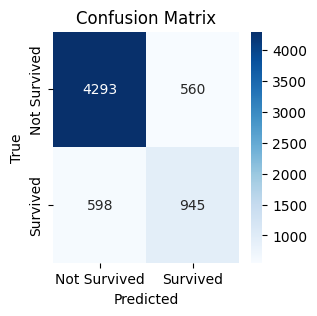

In [9]:
# Plotting the metrics
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('graphs/confusion_matrix1.png')
plt.show()

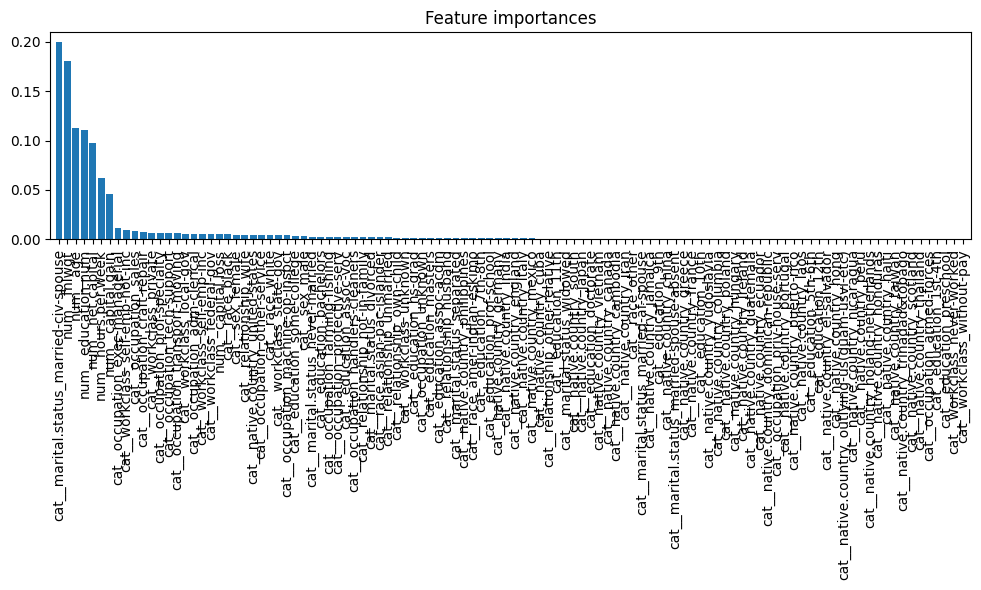

In [10]:
# Plotting importance of features
importances = model.named_steps['classifier'].feature_importances_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.savefig('graphs/feature_importance1.png')
plt.show()

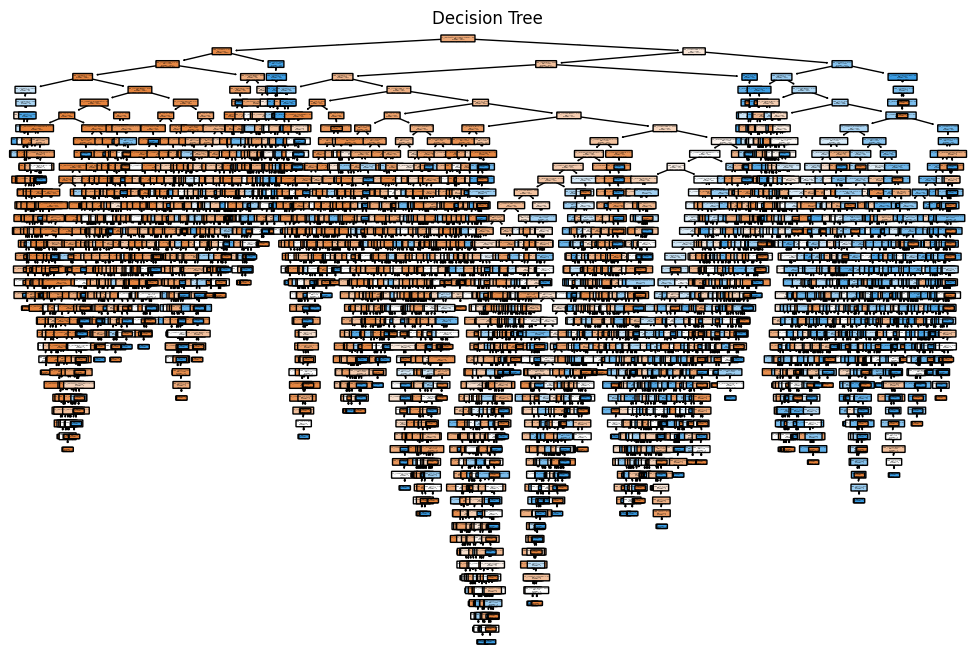

In [11]:
# Plotting the decision tree
plt.figure(figsize=(12, 8))
plot_tree(model.named_steps['classifier'], feature_names=feature_names, filled=True, rounded=True)
plt.title("Decision Tree")
plt.savefig('graphs/decision_tree1.png')
plt.show()

In [12]:
# Save the model
joblib.dump(model, 'titanic_model_DT.pkl')
# Load the model
loaded_model = joblib.load('titanic_model_DT.pkl')

### Training the Model with Hyperparameter Tuning

In [13]:
# Making a Classifier
classifier = DecisionTreeClassifier(
    max_depth=10,              # limits the tree depth
    random_state=42
)

In [14]:
# New Pipeline with the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

In [15]:
# Evaluate the model with the new classifier
model = pipeline.fit(X_train, y_train)

Accuracy: 0.8558474046278924
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4853
           1       0.79      0.55      0.65      1543

    accuracy                           0.86      6396
   macro avg       0.83      0.75      0.78      6396
weighted avg       0.85      0.86      0.85      6396



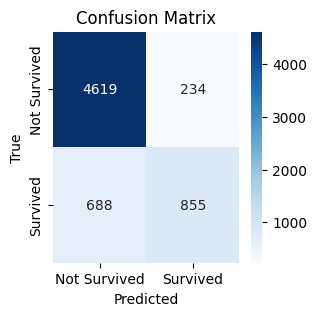

In [16]:
# Plotting the metrics
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('graphs/confusion_matrix2.png')
plt.show()

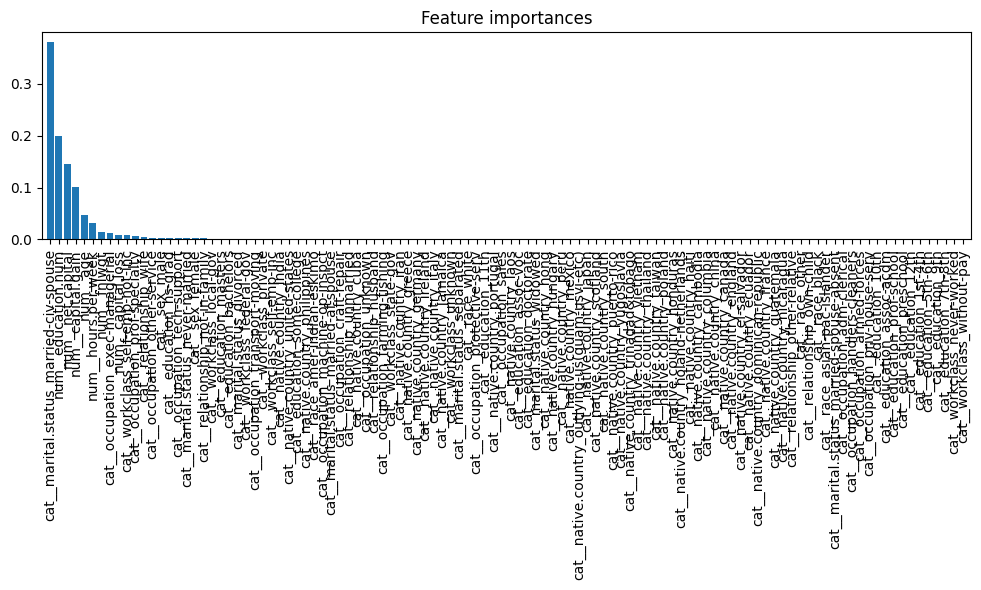

In [17]:
# Plotting importance of features
importances = model.named_steps['classifier'].feature_importances_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.savefig('graphs/feature_importance2.png')
plt.show()

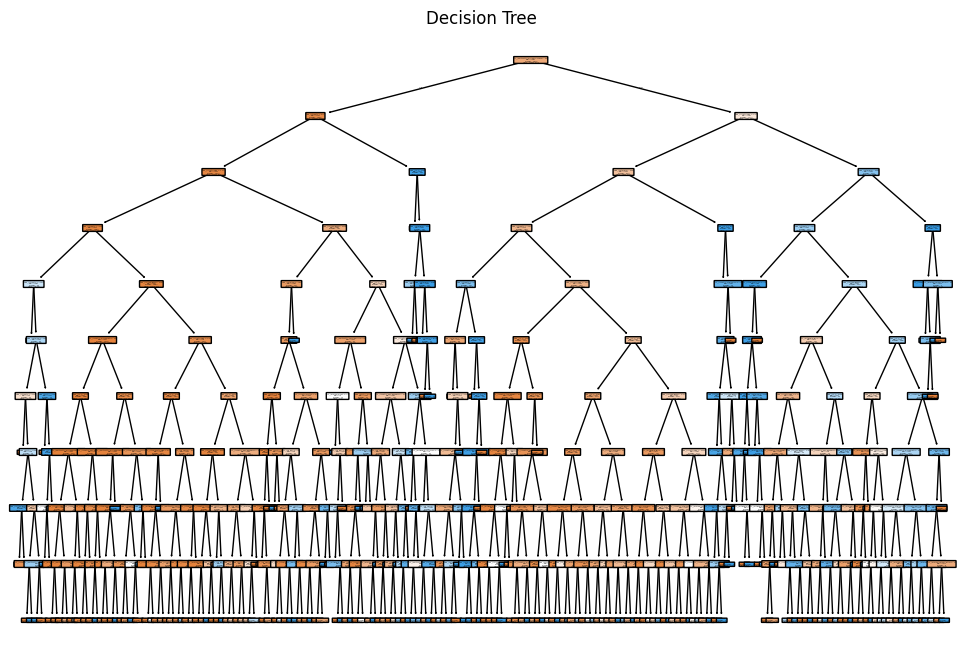

In [18]:
# Plotting the decision tree
plt.figure(figsize=(12, 8))
plot_tree(model.named_steps['classifier'], feature_names=feature_names, filled=True, rounded=True)
plt.title("Decision Tree")
plt.savefig('graphs/decision_tree2.png')
plt.show()

### Dropping Unnecessary Features

In [19]:
# Get feature names from column transformer
features = model.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = features.get_feature_names_out(categorical_features)

# Full feature list
feature_names = np.concatenate([numeric_features, cat_feature_names])

# Get feature importances
importances = model.named_steps['classifier'].feature_importances_

In [20]:
# Creating a mask for important features
important_features_mask = importances > 0.01  # Adjust threshold as needed

# Applying the mask to feature names
important_feature_names = feature_names[important_features_mask]

# Unimportant features
unimportant_feature_names = feature_names[~important_features_mask]

In [21]:
# Dropping unimportant features from the dataset
X_train_reduced = X_train.drop(columns=unimportant_feature_names, errors='ignore')
X_test_reduced = X_test.drop(columns=unimportant_feature_names, errors='ignore')
# Making new numerical and categorical features lists
numeric_features_reduced = [col for col in numeric_features if col in X_train_reduced.columns]
categorical_features_reduced = [col for col in categorical_features if col in X_train_reduced.columns]
# New preprocessor with reduced features
preprocessor_reduced = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_reduced),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_reduced)
    ])


In [22]:
# Adjusting the hyperparameters of the classifier
classifier = DecisionTreeClassifier(
    max_depth=10,              # limits the tree depth
    random_state=42
)

In [23]:
# Create a new pipeline with reduced features
pipeline_reduced = Pipeline(steps=[
    ('preprocessor', preprocessor_reduced),
    ('classifier', classifier)
])
# Train the model with reduced features
model = pipeline_reduced.fit(X_train_reduced, y_train)

Accuracy: 0.8556910569105691
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4853
           1       0.78      0.55      0.65      1543

    accuracy                           0.86      6396
   macro avg       0.83      0.75      0.78      6396
weighted avg       0.85      0.86      0.85      6396



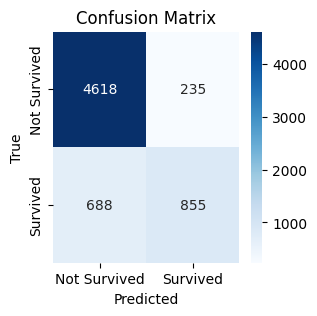

In [24]:
# Plotting the metrics
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('graphs/confusion_matrix3.png')
plt.show()

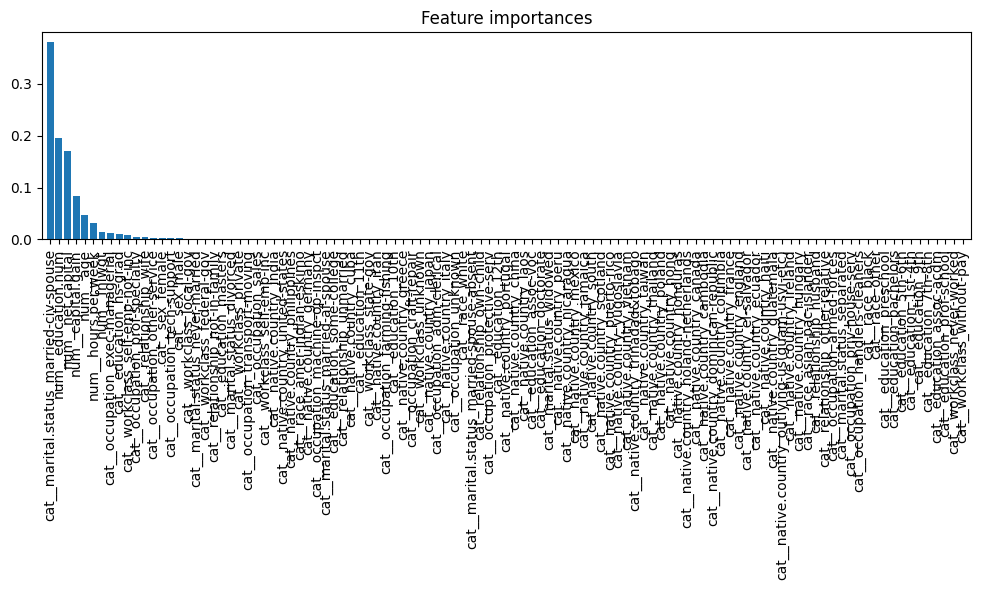

In [26]:
# Plotting importance of features
importances = model.named_steps['classifier'].feature_importances_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.savefig('graphs/feature_importance3.png')
plt.show()

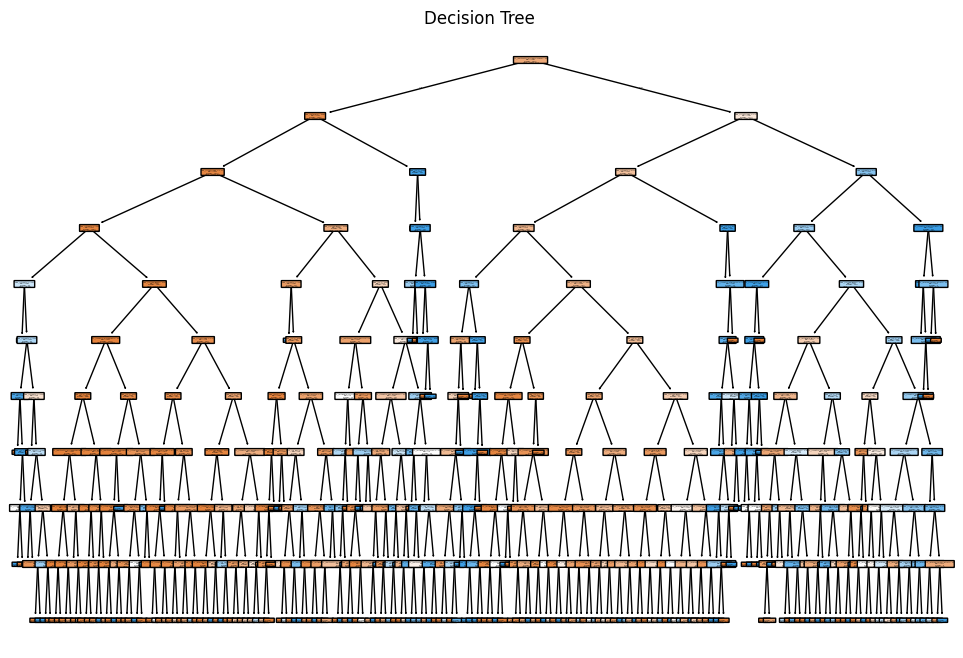

In [27]:
# Plotting the decision tree
plt.figure(figsize=(12, 8))
plot_tree(model.named_steps['classifier'], feature_names=feature_names, filled=True, rounded=True)
plt.title("Decision Tree")
plt.savefig('graphs/decision_tree3.png')
plt.show()